In [662]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from Lib.fill_nan import fill_nan_by_knn

In [648]:
train_df = pd.read_csv("train_house_price.csv")
test_df = pd.read_csv("test_house_price.csv")
data = pd.concat([train_df, test_df], axis=0, ignore_index=True)
data.shape

(2919, 81)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [Text(0, 0, 'PoolQC'),
  Text(1, 0, 'MiscFeature'),
  Text(2, 0, 'Alley'),
  Text(3, 0, 'Fence'),
  Text(4, 0, 'MasVnrType'),
  Text(5, 0, 'SalePrice'),
  Text(6, 0, 'FireplaceQu'),
  Text(7, 0, 'LotFrontage'),
  Text(8, 0, 'GarageYrBlt'),
  Text(9, 0, 'GarageFinish'),
  Text(10, 0, 'GarageQual'),
  Text(11, 0, 'GarageCond'),
  Text(12, 0, 'GarageType'),
  Text(13, 0, 'BsmtExposure'),
  Text(14, 0, 'BsmtCond'),
  Text(15, 0, 'BsmtQual'),
  Text(16, 0, 'BsmtFinType2'),
  Text(17, 0, 'BsmtFinType1'),
  Text(18, 0, 'MasVnrArea'),
  Text(19, 0, 'MSZoning'),
  Text(20, 0, 'Functional'),
  Text(21, 0, 'BsmtFullBath'),
  Text(22, 0, 'Utilities'),
  Text(23, 0, 'BsmtHalfBath'),
  Text(24, 0, 'Electrical'),
  Text(25, 0, 'TotalBsmtSF'),
  Text(26, 0, 'BsmtUnfSF'),
  Text(27, 0, 'KitchenQual'),
  

C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 36986 (\N{CJK UNIFIED IDEOGRAPH-907A}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 28431 (\N{CJK UNIFIED IDEOGRAPH-6F0F}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Pyt

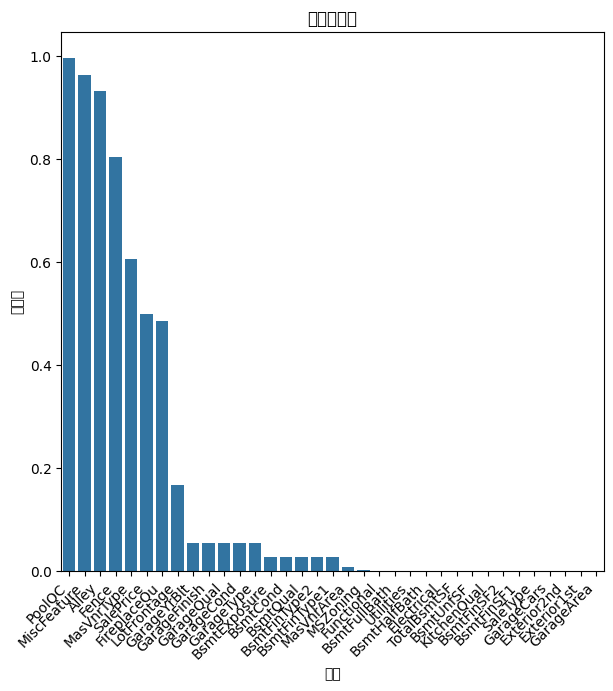

In [649]:
# 遺漏值確認
missing_columns = data.isnull().mean().sort_values(ascending=False)
missing_columns = missing_columns[missing_columns !=
                                  0].to_frame().reset_index()

# 遺漏率繪圖
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='index', y=0, data=missing_columns)
ax.set(xlabel='特徵', ylabel='遺漏率', title='特徵遺漏率')
plt.xticks(rotation=45, ha="right")  # 調整標籤旋轉角度

In [650]:
# 刪除有過多缺失值的col 及 id, saleprice col
saleprice_data = data["SalePrice"]
data.drop(['Id', "SalePrice", 'PoolQC', 'MiscFeature',
          'Alley', 'Fence'], axis=1, inplace=True)

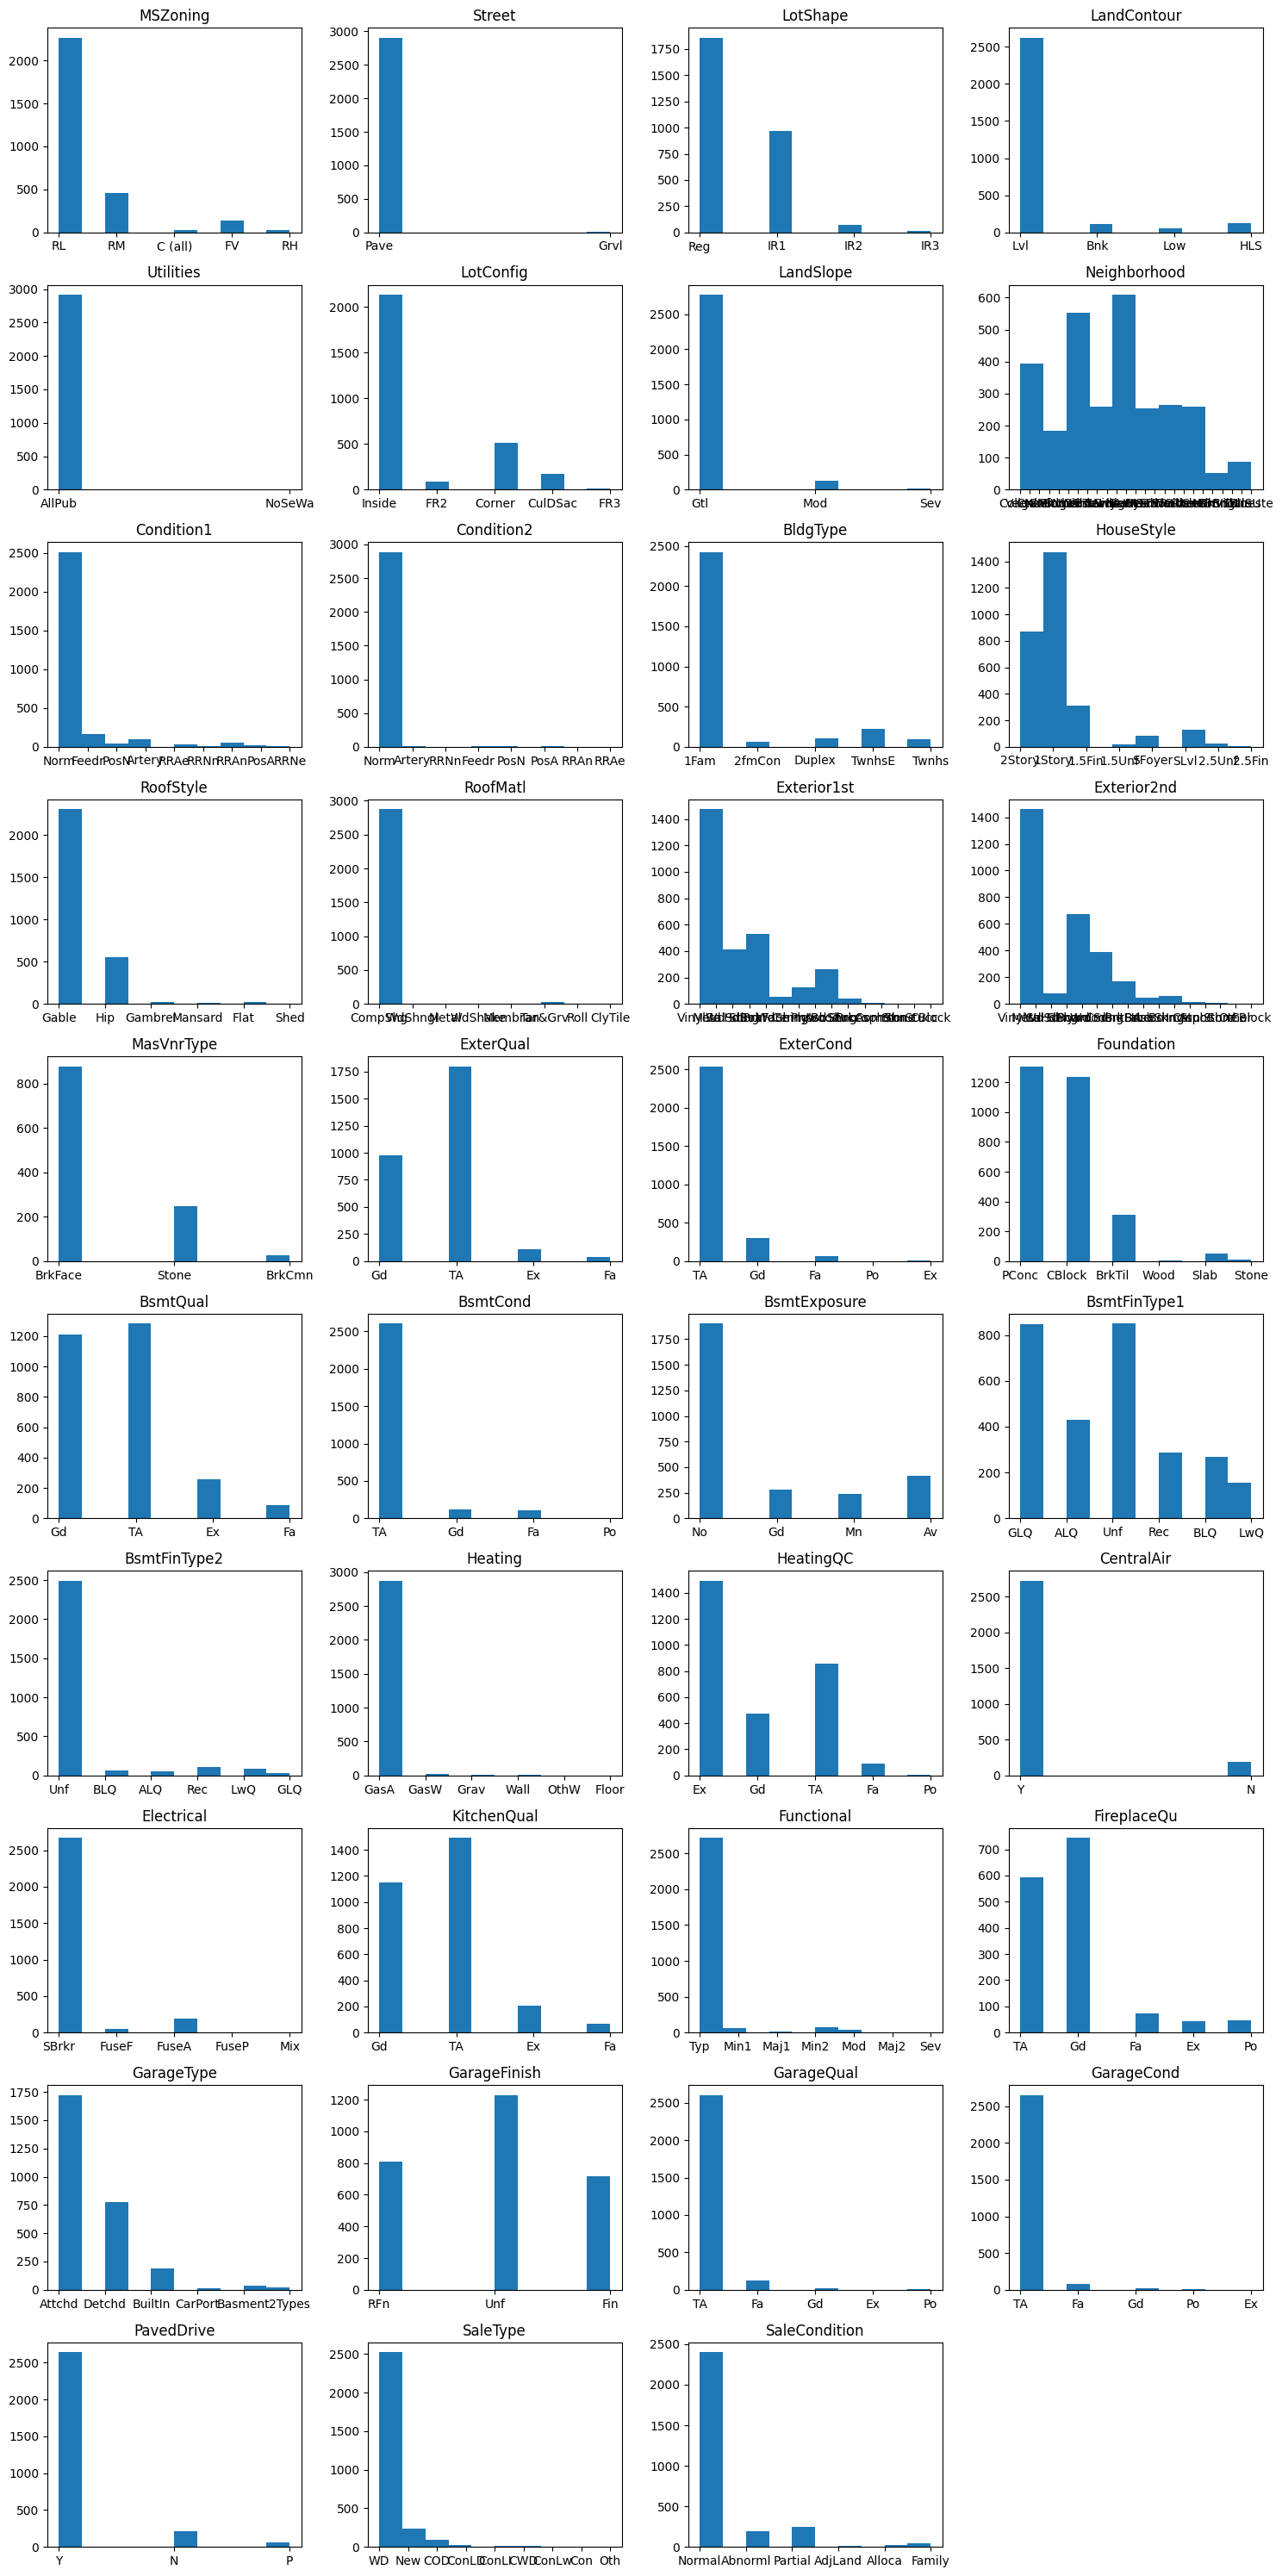

In [651]:
# 觀察object_data
object_data = data.select_dtypes(include=['object'])
num_cols_per_row = 4

# 計算總行數
num_rows = (len(object_data.columns) // num_cols_per_row) + 1

# 設置 subplot
fig, axes = plt.subplots(num_rows, num_cols_per_row,
                         figsize=(15, 3 * num_rows))

# 平坦化二維陣列
axes = axes.flatten()

# 迭代列並繪製直方圖
for i, column in enumerate(object_data.columns):
    ax = axes[i]
    ax.hist(object_data[column].dropna())
    ax.set_title(column, fontsize=12, color='black')

# 關閉多餘的子圖
for j in range(len(object_data.columns), len(axes)):
    fig.delaxes(axes[j])

# 調整子圖的間距
plt.tight_layout()

# 顯示圖表
plt.show()

In [652]:
# 刪除集中單一類別的 ob_features
data.drop(["Street", "Utilities", "LandSlope", "Condition2",
          "RoofMatl", "Heating", "Functional"], axis=1, inplace=True)

C:\Users\d\AppData\Local\Temp\ipykernel_23104\1798975225.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_data[column].dropna(), ax=axes[i])
C:\Users\d\AppData\Local\Temp\ipykernel_23104\1798975225.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_data[column].dropna(), ax=axes[i]

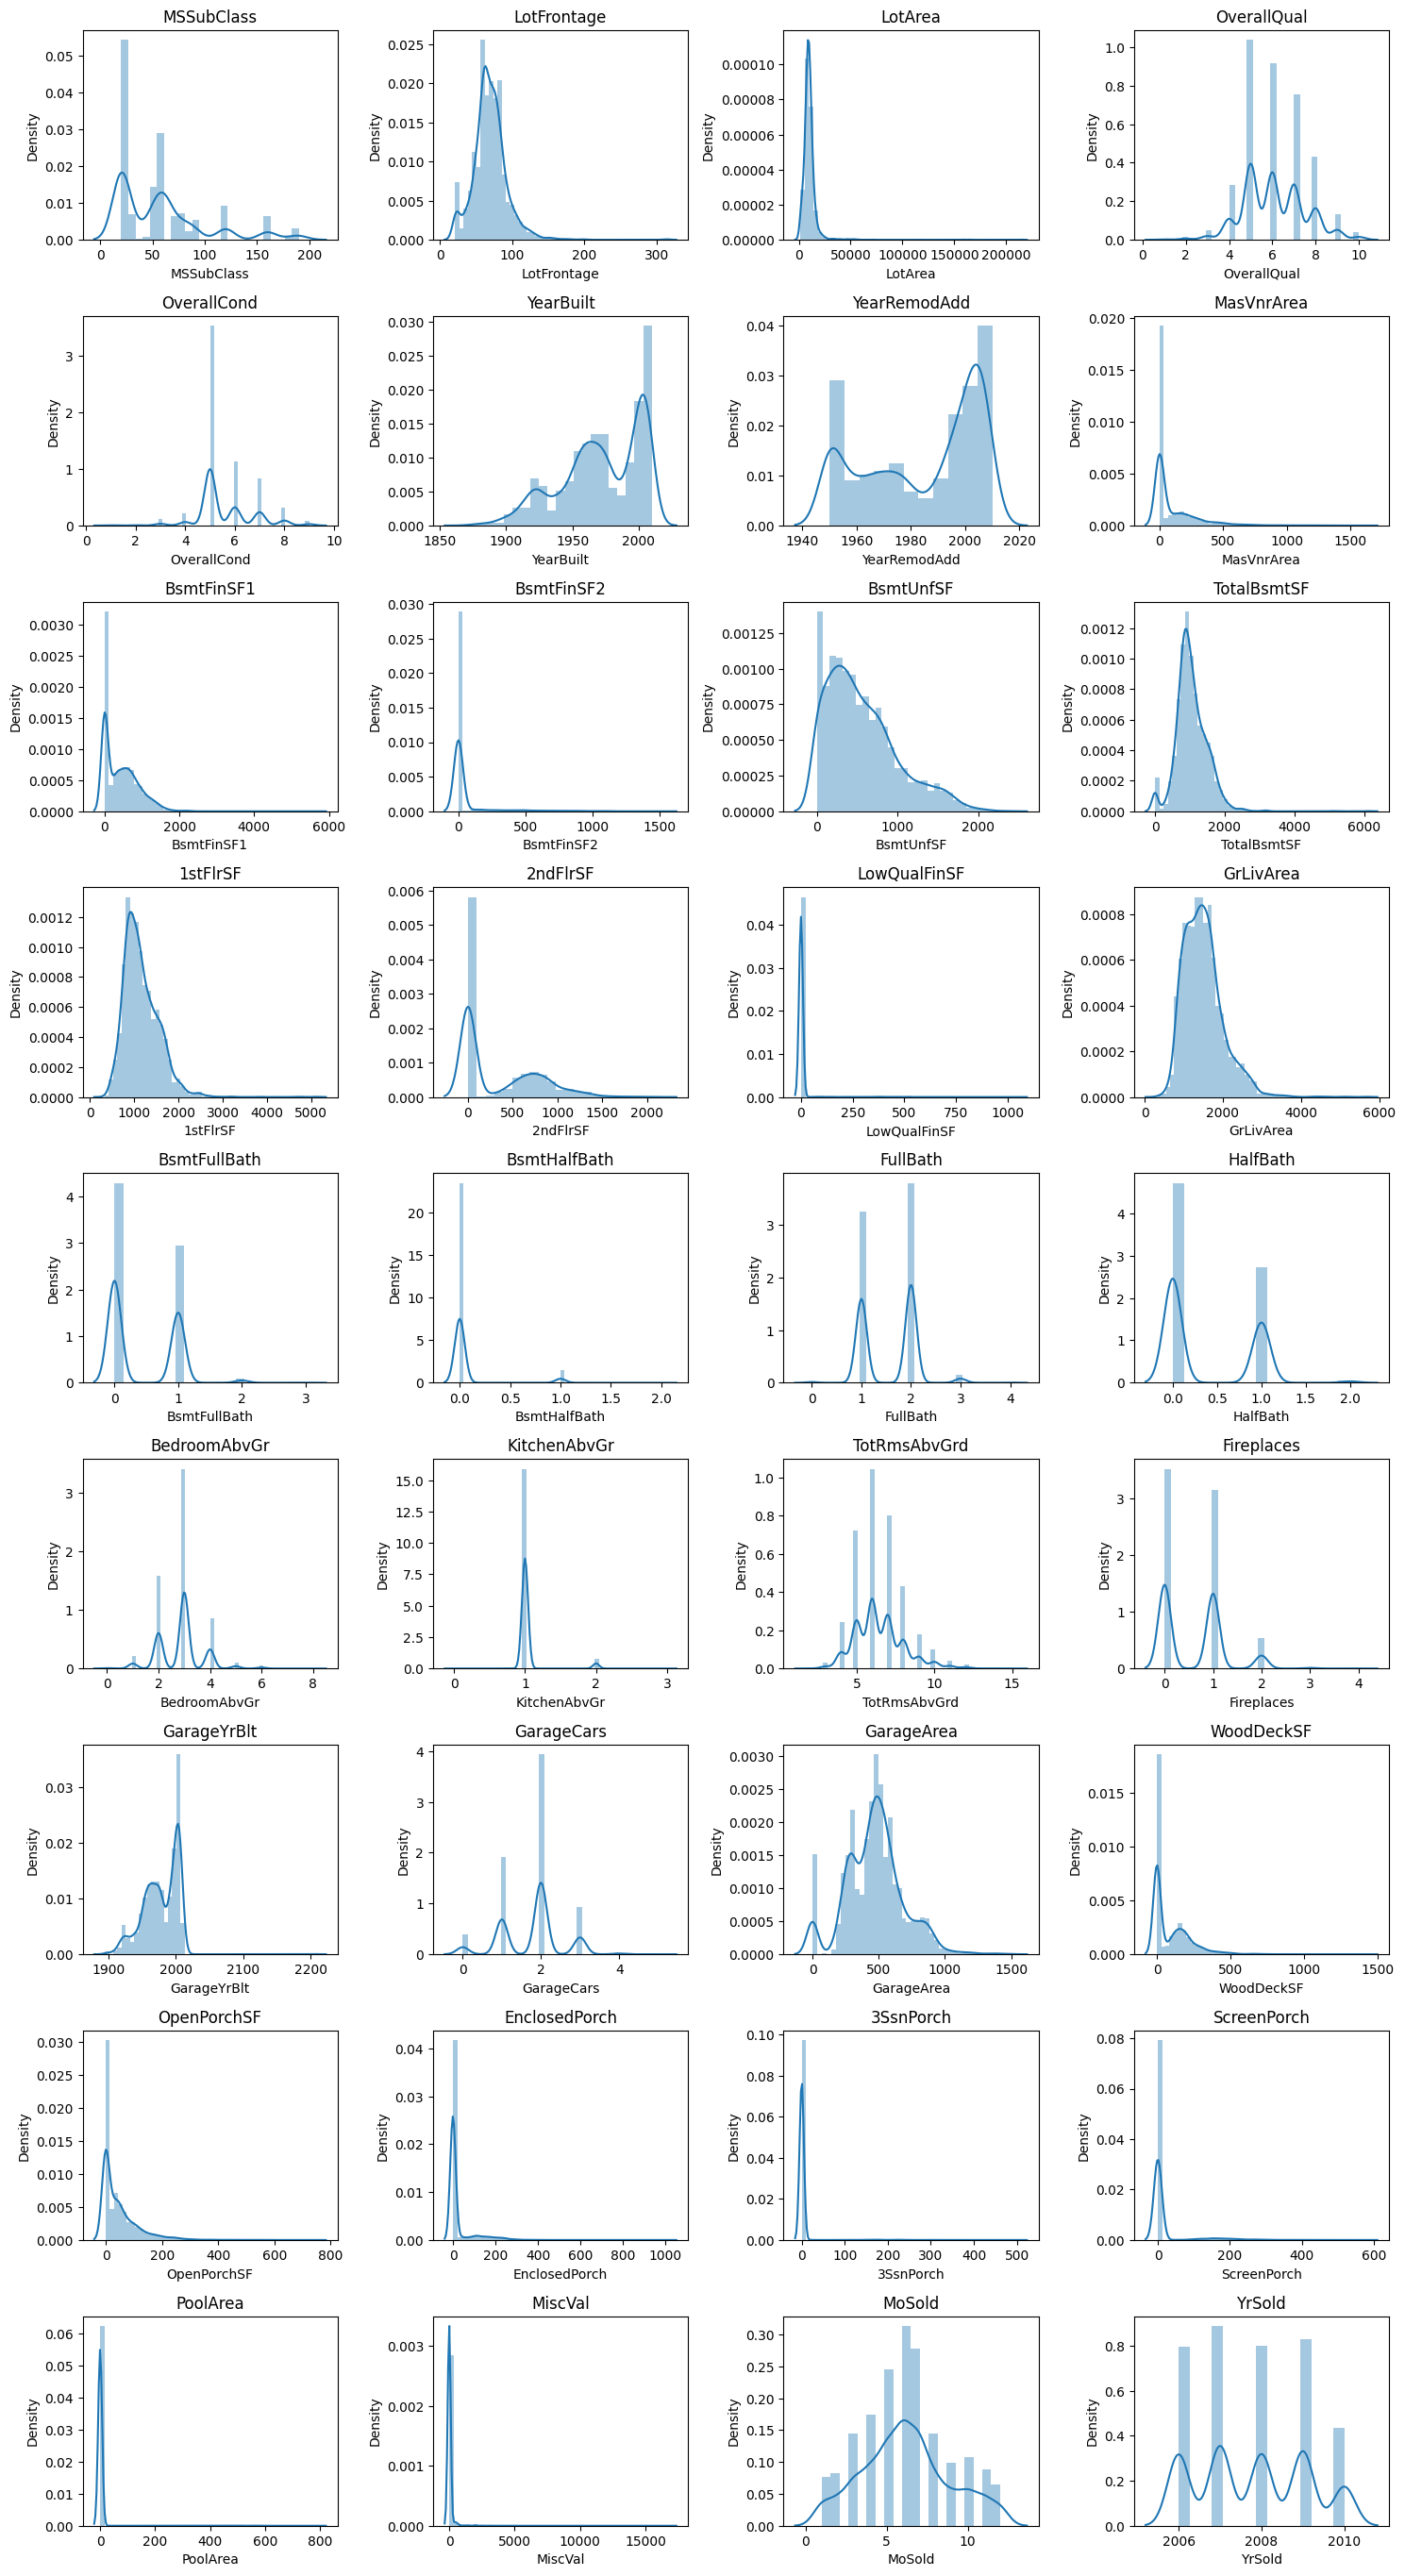

In [653]:
num_data = data.select_dtypes(include=['int', 'float'])
num_cols_per_row = 4

# 計算總行數
num_rows = (len(num_data.columns) // num_cols_per_row) + 1

# 設置 subplot
fig, axes = plt.subplots(num_rows, num_cols_per_row,
                         figsize=(15, 3 * num_rows))

# 平坦化二維陣列
axes = axes.flatten()

# 迭代列並繪製直方圖
for i, column in enumerate(num_data.columns):
    sns.distplot(num_data[column].dropna(), ax=axes[i])
    axes[i].set_title(column)

# 關閉多餘的子圖
for j in range(len(num_data.columns), len(axes)):
    fig.delaxes(axes[j])

# 調整子圖的間距
plt.tight_layout()

# 顯示圖表
plt.show()

In [654]:
# 刪除集中單一類別的num_features
data.drop(["BldgType", "BsmtFinSF2", "LowQualFinSF", "BsmtHalfBath",
          "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"], axis=1, inplace=True)

In [655]:
# 處理object feature

# lebel encoding
columns_to_fillna = ['ExterQual', 'BsmtQual', 'HeatingQC',
                     'KitchenQual', 'FireplaceQu', 'BsmtExposure', 'BsmtFinType1']

# 使用fillna進行缺失值填充
data[columns_to_fillna] = data[columns_to_fillna].fillna('none')

for i in ['ExterQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu']:
    data[i] = data[i].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'none'], [
                              5, 4, 3, 2, 1, 0]).astype(int)

for i in ['BsmtExposure']:
    data[i] = data[i].replace(['Gd', 'Av', 'Mn', 'No', 'none'], [
                              4, 3, 2, 1, 0]).astype(int)

for i in ['BsmtFinType1']:
    data[i] = data[i].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'none'], [
                              6, 5, 4, 3, 2, 1, 0]).astype(int)

# 銷售時屋齡
data['House_year'] = data['YrSold']-data['YearBuilt']

# 年月份、MSSubClass轉類別
for i in ['YrSold', 'MSSubClass', 'MoSold']:
    data_all[i] = data_all[i].astype(str)

# one-hot encoding
data_final = pd.get_dummies(data, dtype=int)

In [656]:
# 填補缺失值
data_final = fill_nan_by_knn(data_final, 3, "skip")

In [657]:
# 極端值處理
num_data = data.select_dtypes(include=['int', 'float'])

# 找出常態分佈的features
normal_distributed_features = []
for feature in num_data:
    stat, p_value = shapiro(data[feature])
    if p_value > 0.05:
        normal_distributed_features.append(feature)

# 刪除於常態分佈features中95%區間外的值
for feature in normal_distributed_features:
    mean_val = data_final[feature].mean()
    std_val = data_final[feature].std()
    lower_bound = mean_val - 1.96 * std_val
    upper_bound = mean_val + 1.96 * std_val

    # 刪除超出區間的值
    data_final = data_final[(data[feature] >= lower_bound) & (
        data_final[feature] <= upper_bound)]

# print("刪除95%區間之外的值後的DataFrame：")

C:\Users\d\AppData\Local\Temp\ipykernel_23104\2987705612.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_final = data_final[(data[feature] >= lower_bound) & (data_final[feature] <= upper_bound)]
C:\Users\d\AppData\Local\Temp\ipykernel_23104\2987705612.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_final = data_final[(data[feature] >= lower_bound) & (data_final[feature] <= upper_bound)]
C:\Users\d\AppData\Local\Temp\ipykernel_23104\2987705612.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_final = data_final[(data[feature] >= lower_bound) & (data_final[feature] <= upper_bound)]
C:\Users\d\AppData\Local\Temp\ipykernel_23104\2987705612.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_final = data_final[(data[feature] >= lower_bound) & (data_final[feature] <= upper_bound)]
C:\Users\d\AppData\Local\Temp\ipykernel_23104\298770

OverallQual         0.724924
GrLivArea           0.644571
FullBath            0.614121
ExterQual           0.576092
KitchenQual         0.572416
YearBuilt           0.545274
BsmtQual_Gd         0.537797
YearRemodAdd        0.526590
GarageCars          0.497426
Foundation_PConc    0.482129
Name: SalePrice, dtype: float64


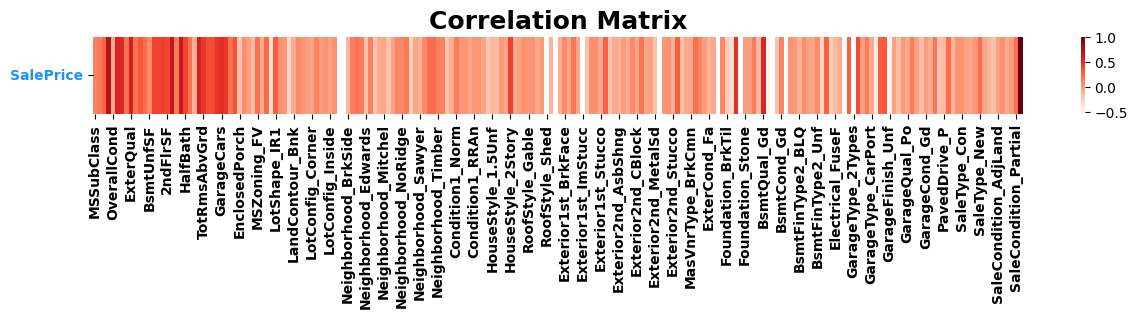

In [658]:
# 相關性熱點圖
num_data_final = data_final.select_dtypes(include=['int', 'float'])

# 合併 'SalePrice' 到 num_data_final
num_data_final = pd.concat([num_data_final, saleprice_data], axis=1)

# 計算相關性
num_corr = num_data_final.corr()

# 調整圖形大小
fig, ax = plt.subplots(figsize=(15, 1))

# 繪製相關性熱點圖
sns.heatmap(num_corr.sort_values(
    by=['SalePrice'], ascending=False).head(1), cmap='Reds')

# 設置標題和軸標籤
plt.title("Correlation Matrix", weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

# 顯示前10個特徵與 'SalePrice' 的相關性
print(num_corr['SalePrice'].sort_values(ascending=False).iloc[1:11])

In [663]:
# split train and validate data
x_train, x_test = train_test_split(data_final, test_size=0.3, random_state=321)